In [2]:
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimage
import torchvision.utils as vutils
import matplotlib.colors as c
from torch import tensor

In [3]:
import glob
import os
from PIL import Image
import torchvision.transforms as T

In [4]:
import torch

### Preprocessing Code

#### Calculate Weight

In [5]:
# helper methods for preprocessing
def calculate_weight(channels, depth, single_color, color_opponency, black_white):
    weight_array = np.ones((channels, depth * 3, 1, 1))

    if depth == 1:
        if not single_color and not color_opponency and not black_white: # Average black-white image
            weight_array[:, :3, :, :] *= 1 / 3
        elif color_opponency and not single_color and not black_white: #color opponency depth 0
            weight_array[0,:,:,:] = 1/3
            for i in range(3):
                weight_array[1, i, 0, 0] = [0.5, -0.5, 0][i]
                weight_array[2, i, 0, 0] = [-0.5 / 3, -0.5 / 3, 1 / 3][i]
        elif black_white and not color_opponency and not single_color: # Luminance black-white image
            print("black_white")
            weight_array[:, 0, :, :] *= 0.299
            weight_array[:, 1, :, :] *= 0.587
            weight_array[:, 2, :, :] *= 0.114
    else:
        weight_array[:, :3, :, :] *= 1 / 3
        weight_array[:, 3:, :, :] *= -(1 / (depth * 3 - 3))

        if channels == 3 and single_color:
            print("single_color")
            for c in range(channels):
                weight_array[c, :, 0, 0] = 0  # Setze alles auf 0
                weight_array[c, c, 0, 0] = 1  # Setze die 1 an die richtige Stelle

                for i in range(1, depth):
                    weight_array[c, i * 3 + c, 0, 0] = -1 / (depth - 1)

        elif channels == 3 and color_opponency:
            print("color_opponency")
            copy = weight_array[0, :, :, :]
            weight_array = np.zeros((channels, depth * 3, 1, 1))
            weight_array[0, :, :, :] = copy
            base_r_g = [0.5, -0.5, 0]
            r_g_value = [-(1 / ((depth - 1) * 2)), (1 / ((depth - 1) * 2)), 0]
            base_b_y = [-0.5 / 3, -0.5 / 3, 1 / 3]
            b_y_value = [(0.5 / (depth * 3 - 3)), (0.5 / (depth * 3 - 3)), -(1 / (depth * 3 - 3))]

            for i in range(depth * 3):
                if i < 3:
                    # Setze die ersten drei Werte direkt auf 0.5, -0.5, 0
                    weight_array[1, i, 0, 0] = base_r_g[i]
                    weight_array[2, i, 0, 0] = base_b_y[i]
                else:
                    # Fülle den Rest mit dem Pattern entsprechend depth
                    index = (i - 3) % 3
                    weight_array[1, i, 0, 0] = r_g_value[index]
                    weight_array[2, i, 0, 0] = b_y_value[index]



    return weight_array

def create_blur_kernel():
    kernel = np.zeros((3, 3))

    for i in range(3):
        for j in range(3):
            kernel[i, j] = 1 / 9

    return kernel

#### Save Image Methods

In [6]:
def save_image_co(image_tensor, where, image_name, channels, savepath, single_channel_images=True):

    os.makedirs(savepath, exist_ok=True)

    cmap_R = c.LinearSegmentedColormap.from_list("cmap_R",
                                                 ['black', 'white'])  # hier sind die colormaps definiert,
    cmap_G = c.LinearSegmentedColormap.from_list("cmap_G", ['#0f0', 'white',
                                                            '#f00'])  # in denen die channel angezeigt werden
    cmap_B = c.LinearSegmentedColormap.from_list("cmap_B", ['#00f', 'white',
                                                            'yellow'])

    boundary_red = max(torch.max(image_tensor[0]), -torch.min(image_tensor[0]))

    f, axarr = plt.subplots(5, 4, figsize=(20, 20))

    img_norm = (image_tensor - torch.min(image_tensor)) / (torch.max(image_tensor) - torch.min(image_tensor))
    # img_norm = image_tensor / torch.max(image_tensor)
    axarr[0][0].imshow(img_norm.detach().cpu().permute(1, 2, 0))
    axarr[0][1].imshow(img_norm[0].detach().cpu(), cmap=cmap_R)
    vutils.save_image(img_norm, "" + savepath + "/" + image_name + "-CO.png")
    if single_channel_images:
        mpimage.imsave("" + savepath + "/" + image_name + "-bw.png", img_norm[0].detach().cpu(), cmap=cmap_R,
                   vmin=-boundary_red, vmax=boundary_red)

    if channels > 1 and single_channel_images:
        boundary_green = max(torch.max(image_tensor[1]), -torch.min(image_tensor[1]))
        boundary_blue = max(torch.max(image_tensor[2]), -torch.min(image_tensor[2]))
        axarr[0][2].imshow(img_norm[1].detach().cpu(), cmap=cmap_G)
        axarr[0][3].imshow(img_norm[2].detach().cpu(), cmap=cmap_B)
        mpimage.imsave("" + savepath + "/" + image_name + "-rg.png", img_norm[1].detach().cpu(), cmap=cmap_G,
                       vmin=-boundary_green, vmax=boundary_green)
        mpimage.imsave("" + savepath + "/" + image_name + "-bg.png", img_norm[2].detach().cpu(), cmap=cmap_B,
                       vmin=-boundary_blue, vmax=boundary_blue)

    plt.close()

def save_image_bw(image_tensor, where, image_name, channels, savepath, single_channel_images=True):


    os.makedirs(savepath, exist_ok=True)


    cmap_R = c.LinearSegmentedColormap.from_list("cmap_R",
                                                 ['black', 'white'])  # hier sind die colormaps definiert, in denen die channel angezeigt werden


    boundary_red = max(torch.max(image_tensor[0]), -torch.min(image_tensor[0]))

    f, axarr = plt.subplots(5, 4, figsize=(20, 20))

    img_norm = (image_tensor - torch.min(image_tensor)) / (torch.max(image_tensor) - torch.min(image_tensor))
    # img_norm = image_tensor / torch.max(image_tensor)
    axarr[0][0].imshow(img_norm.detach().cpu().permute(1, 2, 0))
    axarr[0][1].imshow(img_norm[0].detach().cpu(), cmap=cmap_R)
    vutils.save_image(img_norm, "" + savepath + "/" + image_name + "-GRAY.png")
    if single_channel_images:
        mpimage.imsave("" + savepath + "/" + image_name + "-bw.png", img_norm[0].detach().cpu(), cmap=cmap_R,
                   vmin=-boundary_red, vmax=boundary_red)

    if channels > 1 and single_channel_images:
        boundary_green = max(torch.max(image_tensor[1]), -torch.min(image_tensor[1]))
        boundary_blue = max(torch.max(image_tensor[2]), -torch.min(image_tensor[2]))
        axarr[0][2].imshow(img_norm[1].detach().cpu(), cmap=cmap_R)
        axarr[0][3].imshow(img_norm[2].detach().cpu(), cmap=cmap_R)
        mpimage.imsave("" + savepath + "/" + image_name + "-rg.png", img_norm[1].detach().cpu(), cmap=cmap_R,
                       vmin=-boundary_green, vmax=boundary_green)
        mpimage.imsave("" + savepath + "/" + image_name + "-bg.png", img_norm[2].detach().cpu(), cmap=cmap_R,
                       vmin=-boundary_blue, vmax=boundary_blue)

    plt.close()

def save_image_rgb(image_tensor, where, image_name, channels, savepath, single_channel_images=True):



    os.makedirs(savepath, exist_ok=True)

    # Path(path + "/" + savepath +"/" + save_name).mkdir(parents=True, exist_ok=True)

    cmap_R = c.LinearSegmentedColormap.from_list("cmap_R",
                                                 ['black', 'white', '#f00'])  # hier sind die colormaps definiert,
    cmap_G = c.LinearSegmentedColormap.from_list("cmap_G", ['black', 'white',
                                                            '#0f0'])  # in denen die channel angezeigt werden
    cmap_B = c.LinearSegmentedColormap.from_list("cmap_B", ['black', 'white', '#00f'])

    boundary_red = max(torch.max(image_tensor[0]), -torch.min(image_tensor[0]))

    f, axarr = plt.subplots(5, 4, figsize=(20, 20))

    img_norm = (image_tensor - torch.min(image_tensor)) / (torch.max(image_tensor) - torch.min(image_tensor))
    # img_norm = image_tensor / torch.max(image_tensor)
    axarr[0][0].imshow(img_norm.detach().cpu().permute(1, 2, 0))
    axarr[0][1].imshow(img_norm[0].detach().cpu(), cmap=cmap_R)
    vutils.save_image(img_norm, "" + savepath + "/" + image_name + "-RGB.png")
    if single_channel_images:
        mpimage.imsave("" + savepath + "/" + image_name + "-r.png", img_norm[0].detach().cpu(), cmap=cmap_R,
                   vmin=-boundary_red, vmax=boundary_red)

    if channels > 1 and single_channel_images:
        boundary_green = max(torch.max(image_tensor[1]), -torch.min(image_tensor[1]))
        boundary_blue = max(torch.max(image_tensor[2]), -torch.min(image_tensor[2]))
        axarr[0][2].imshow(img_norm[1].detach().cpu(), cmap=cmap_G)
        axarr[0][3].imshow(img_norm[2].detach().cpu(), cmap=cmap_B)
        mpimage.imsave("" + savepath + "/" + image_name + "-g.png", img_norm[1].detach().cpu(), cmap=cmap_G,
                       vmin=-boundary_green, vmax=boundary_green)
        mpimage.imsave("" + savepath + "/" + image_name + "-b.png", img_norm[2].detach().cpu(), cmap=cmap_B,
                       vmin=-boundary_blue, vmax=boundary_blue)

    plt.close()

#### Preprocessing Module

In [7]:
class BlurPreprocessing(nn.Module):
    def __init__(self, blur_bool, blur_depth, single_color, color_opponency, channels, path, training, black_white):
        super().__init__()
        self.blur = blur_bool
        self.num_images = blur_depth + 1
        self.single_color = single_color
        self.color_opponency = color_opponency
        self.channels = channels
        self.write = False
        self.path = path
        self.training = training
        self.black_white = black_white

        if self.blur:

            blur_kernel = create_blur_kernel()
            self.conv_blur = nn.Conv2d(3, 3 * self.num_images, 3, stride=(1, 1), padding=1, groups=3, bias=False)

            self.conv_blur.weight = nn.Parameter(tensor(np.array([[blur_kernel],
                                                                  [blur_kernel],
                                                                  [blur_kernel]]), requires_grad=False).float())

            for param in self.conv_blur.parameters():
                param.requires_grad = False

            self.custom_layer = nn.Conv2d(self.num_images * 3, out_channels=channels, kernel_size=1,
                                          stride=1, padding=0, bias=False)

            weight_array = calculate_weight(self.channels, self.num_images, self.single_color, self.color_opponency, self.black_white)
            self.custom_layer.weight = nn.Parameter(tensor(np.array(weight_array), requires_grad=True).float())


            # freezing the preprocessing
            for param in self.custom_layer.parameters():
                param.requires_grad = False

            self.change_channel_layer = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=1, stride=1, padding=0)

            print("preprocessing")
            print(self.conv_blur.weight)
            print(self.custom_layer.weight)

    def forward(self, x, save_name="image"):
        if self.blur:


            concat_image = x

            for i in range(self.num_images - 1):
                x = self.conv_blur(x)
                concat_image = torch.concat([concat_image, x], dim=1)

            x = self.custom_layer(concat_image)

            if self.channels == 1:
                x = self.change_channel_layer(x)


        if self.write:
            if(save_name=="image"):
                if(self.color_opponency):
                    save_name = "color_opponency"
                if self.single_color:
                    save_name = "single_color"
                if self.black_white:
                    save_name = "black_white"
            
            if(self.color_opponency):
                print("saving image after preprocessing")
                save_image_co(x[0], "result", save_name, self.channels, self.path, True)
            if self.single_color:
                print("saving image after preprocessing")
                save_image_rgb(x[0], "result", save_name, self.channels, self.path, True)
            if self.black_white:
                print("saving image after preprocessing")
                save_image_bw(x[0].abs(), "result", save_name, self.channels, self.path, True)
        



        return x


#### Sparsity Module

In [8]:

class SparsityPreprocessing(nn.Module):
    def __init__(self, sparsity_type, sparsity_threshold, training):
        super().__init__()
        self.sparsity_type = sparsity_type
        self.sparsity_threshold = sparsity_threshold
        self.training = training

    def forward(self, x):
        if self.sparsity_type is not None:

            if self.sparsity_type == 'percentage':
                num_elements = x.numel()
                k = int(self.sparsity_threshold * num_elements)

                if k > 0:
                    abs_vals = x.abs().flatten()
                    threshold = torch.topk(abs_vals, k, largest=False).values.max()
                    sparse_image = torch.where(x.abs() <= threshold, torch.tensor(0.0, device=x.device), x)
                    x = sparse_image
            else:
                #value based sparsity
                sparse_image = torch.where(x.abs() < self.sparsity_threshold, torch.tensor(0.0, device=x.device), x)
                x = sparse_image

                if not self.training:
                    image_pixel_number = x.numel()
                    number_of_zero_pixels = (sparse_image == 0.0).sum().item()
                    print(f"Eval: Percentage of zero pixels in the sparse image: {number_of_zero_pixels/image_pixel_number}")

        return x


### Image Generation

##### BW Depth5

In [10]:

blur_module = BlurPreprocessing(
    blur_bool=True,
    blur_depth=5,
    single_color=False,
    color_opponency=False,
    channels=3,   # 1 or 3
    path="Processed_Images/Images/bw",
    training=False,
    black_white=True
)

sparse_module = SparsityPreprocessing(
    sparsity_type='percentage',  # 'percentage' or 'value' or None
    sparsity_threshold=0.8,  # for 'percentage' between 0 and 1, for 'value' the threshold value
    training=False
)

# Transform for images
transform = T.Compose([
    T.ToTensor()
])

    # Get all images in ./images
image_files = glob.glob("./images/*fog.*")

for img_path in image_files:
    base = os.path.splitext(os.path.basename(img_path))[0]
    print(f"\nProcessing {base} ...")

    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0)  # (1,3,H,W)

    with torch.no_grad():
        out = blur_module(x, save_name=base + "_bw")
        sparse = sparse_module(out)
        # Make all pixels that are 0 to pink for better visibility
        sparse_pink = torch.where(sparse == 0, torch.tensor([1.0, 0.0, 1.0], device=sparse.device).unsqueeze(1).unsqueeze(2), sparse)

        out_min = torch.min(out)
        # set pixels in x to 0 when sparse is 0
        masked_x = torch.where(sparse == 0, torch.tensor([out_min, out_min, out_min], device=sparse.device).unsqueeze(1).unsqueeze(2), out)
    
        #save_image_rgb(sparse_pink[0], "result", base + "_80sparse_pink", 3, "Processed_Images/Images/Sparse/80perc", False)
        save_image_rgb(masked_x[0], "result", base + "_80masked", 3, "Processed_Images/Images/Proc/SparseMasked/80perc", False)

preprocessing
Parameter containing:
tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]],


        [[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]],


        [[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])
Parameter containing:
tensor([[[[ 0.3333]],

         [[ 0.3333]],

         [[ 0.3333]],

         [[-0.0667]],

         [[-0.0667]],

         [[-0.0667]],

         [[-0.0667]],

         [[-0.0667]],

         [[-0.0667]],

         [[-0.0667]],

         [[-0.0667]],

         [[-0.0667]],

         [[-0.0667]],

         [[-0.0667]],

         [[-0.0667]],

         [[-0.0667]],

         [[-0.0667]],

         [[-0.0667]]],


        [[[ 0.3333]],

         [[ 0.3333]],

         [[ 0.3333]],

         [[-0.0667]],

         [[-0.0667]],

         [[-0.0667]],

         [[-0.0667]],

         [[-0.0667]],

       

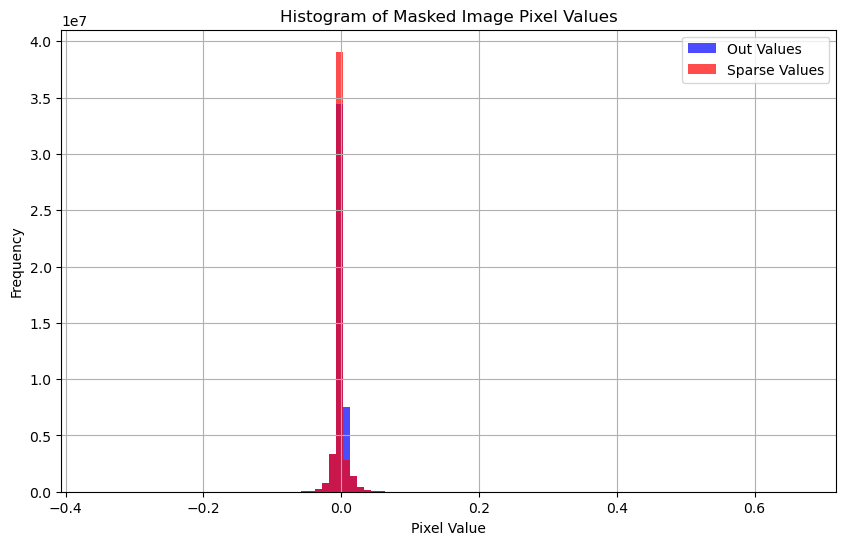

In [ ]:
# Visualize distribution of input image and output image after preprocessing






In [ ]:
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Histogram of 'out' values
out_flat = out.detach().cpu().numpy().flatten()
axes[0, 0].hist(out_flat, bins=50, edgecolor='black', alpha=0.7, color='blue')
axes[0, 0].set_title('Distribution of out values', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_yscale('log')
axes[0, 0].grid(alpha=0.3)

# Plot 2: KDE plot of 'out' values
sns.kdeplot(data=out_flat, ax=axes[0, 1], color='blue', fill=True, alpha=0.6)
axes[0, 1].set_title('KDE Distribution of out values', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(alpha=0.3)

# Plot 3: Histogram of 'sparse' values (excluding zeros for better visibility)
sparse_flat = sparse.detach().cpu().numpy().flatten()
sparse_nonzero = sparse_flat[sparse_flat != 0]
axes[1, 0].hist(sparse_nonzero, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_title(f'Distribution of non-zero sparse values\n({len(sparse_nonzero)} non-zero out of {len(sparse_flat)} total)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Value')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(alpha=0.3)

# Plot 4: KDE plot of 'sparse' values (non-zero)
if len(sparse_nonzero) > 1:
    sns.kdeplot(data=sparse_nonzero, ax=axes[1, 1], color='green', fill=True, alpha=0.6)
else:
    axes[1, 1].text(0.5, 0.5, 'Not enough non-zero values for KDE', ha='center', va='center', transform=axes[1, 1].transAxes)
axes[1, 1].set_title('KDE Distribution of non-zero sparse values', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Value')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n=== OUT VALUES ===")
print(f"Min: {out.min():.4f}, Max: {out.max():.4f}, Mean: {out.mean():.4f}, Std: {out.std():.4f}")
print(f"Total elements: {out.numel()}")

print(f"\n=== SPARSE VALUES ===")
print(f"Min: {sparse.min():.4f}, Max: {sparse.max():.4f}, Mean: {sparse.mean():.4f}, Std: {sparse.std():.4f}")
print(f"Total elements: {sparse.numel()}")
print(f"Non-zero elements: {(sparse != 0).sum().item()} ({100 * (sparse != 0).sum().item() / sparse.numel():.2f}%)")
print(f"Zero elements: {(sparse == 0).sum().item()} ({100 * (sparse == 0).sum().item() / sparse.numel():.2f}%)")

In [ ]:
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Histogram of 'out' values
out_flat = out.detach().cpu().numpy().flatten()
axes[0, 0].hist(out_flat, bins=50, edgecolor='black', alpha=0.7, color='blue')
axes[0, 0].set_title('Distribution of out values', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_yscale('log')
axes[0, 0].grid(alpha=0.3)

# Plot 2: KDE plot of 'out' values
sns.kdeplot(data=out_flat, ax=axes[0, 1], color='blue', fill=True, alpha=0.6)
axes[0, 1].set_title('KDE Distribution of out values', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(alpha=0.3)

# Plot 3: Histogram of 'sparse' values (excluding zeros for better visibility)
sparse_flat = sparse.detach().cpu().numpy().flatten()
sparse_nonzero = sparse_flat[sparse_flat != 0]
axes[1, 0].hist(sparse_nonzero, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_title(f'Distribution of non-zero sparse values\n({len(sparse_nonzero)} non-zero out of {len(sparse_flat)} total)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Value')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(alpha=0.3)

# Plot 4: KDE plot of 'sparse' values (non-zero)
if len(sparse_nonzero) > 1:
    sns.kdeplot(data=sparse_nonzero, ax=axes[1, 1], color='green', fill=True, alpha=0.6)
else:
    axes[1, 1].text(0.5, 0.5, 'Not enough non-zero values for KDE', ha='center', va='center', transform=axes[1, 1].transAxes)
axes[1, 1].set_title('KDE Distribution of non-zero sparse values', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Value')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n=== OUT VALUES ===")
print(f"Min: {out.min():.4f}, Max: {out.max():.4f}, Mean: {out.mean():.4f}, Std: {out.std():.4f}")
print(f"Total elements: {out.numel()}")

print(f"\n=== SPARSE VALUES ===")
print(f"Min: {sparse.min():.4f}, Max: {sparse.max():.4f}, Mean: {sparse.mean():.4f}, Std: {sparse.std():.4f}")
print(f"Total elements: {sparse.numel()}")
print(f"Non-zero elements: {(sparse != 0).sum().item()} ({100 * (sparse != 0).sum().item() / sparse.numel():.2f}%)")
print(f"Zero elements: {(sparse == 0).sum().item()} ({100 * (sparse == 0).sum().item() / sparse.numel():.2f}%)")